In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    # sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sd_paper/analysis_and_figure_code/DataPaths'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

import subjects
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
%matplotlib qt
fig = plt.figure(figsize=(10, 9))
ax1 = fig.add_subplot(311)
ax1.plot([0, 1])
ax2 = fig.add_subplot(312, sharex=ax1)
ax3 = fig.add_subplot(313)

In [3]:
# Create group data frame with placefield firing in each bin (0:50 = MAZE, 50:100 = reMAZE)
from copy import deepcopy
from neuropy.utils.mathutil import min_max_external_scaler

sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info
kw = dict(frate_thresh=0, grid_bin=2)
separate_run_dir = False

tc_all, maze_all, remaze_all = [], [], []
pfcorr_by_dir = {}
for s, sess in enumerate([sessions[0]]):
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    
    # ---- Run direction separated-------
    if separate_run_dir:
        tc_maze, tc_remaze, maze_tc_comb, remaze_tc_comb = [], [], [], []
        for direction in ["up", "down"]:
            maze_run = sess.maze_run[direction]
            pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run, **kw)
            maze_tc_comb.append(pfmaze.tuning_curves)
            tc_maze.append(pfmaze.resample_1D(50).tuning_curves)
    
            remaze_run = sess.remaze_run[direction]
            pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run, **kw)
            remaze_tc_comb.append(pfremaze.tuning_curves)
            tc_remaze.append(pfremaze.resample_1D(50).tuning_curves)
    
        tc_comb = np.hstack((np.vstack(tc_maze), np.vstack(tc_remaze)))
        pfmaze.tuning_curves = np.concatenate(maze_tc_comb, axis=0)
        pfmaze.neuron_ids = np.concatenate((pfmaze.neuron_ids, pfmaze.neuron_ids * -1), axis=0)
        pfremaze.tuning_curves = np.concatenate(remaze_tc_comb, axis=0)
        pfremaze.neuron_ids = np.concatenate((pfremaze.neuron_ids, pfremaze.neuron_ids * -1), axis=0)
        

    # ---- Overall----
    else:
        
        pfmaze = Pf1D(neurons, position=sess.maze, **kw)
        pfremaze=Pf1D(neurons, position=sess.remaze, **kw)

In [4]:
from neuropy.analyses.decoders import Decode1d

decode_maze = Decode1d(neurons=neurons, ratemap=pfremaze, epochs=sess.paradigm['re-maze'], bin_size=0.5)

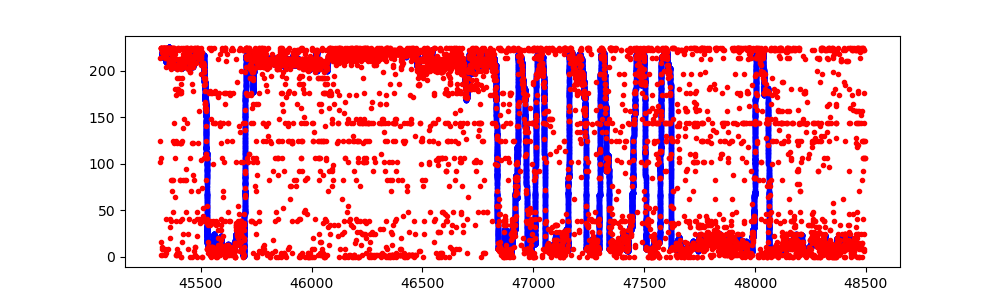

In [5]:
# Simple way to plot
%matplotlib widget
_, ax = plt.subplots(figsize=(10, 3))
speed_thresh = pfremaze.speed > pfremaze.speed_thresh
ax.plot(sess.remaze.time[speed_thresh], sess.remaze.x[speed_thresh], 'b.')
t_decode = sess.paradigm['re-maze'].starts[0] + np.arange(decode_maze.nbins_epochs[0]) * decode_maze.bin_size
ax.plot(t_decode, decode_maze.decoded_position[0], 'r.')

# ax.set_xlim((9900, 10100))

<Axes: >

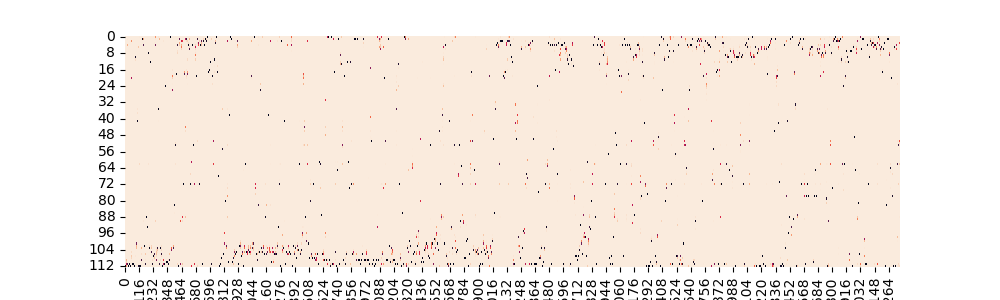

In [6]:
# One way to plot
_, ax = plt.subplots(figsize=(10, 3))
sns.heatmap(decode_maze.posterior[0], cmap="rocket_r", ax=ax, cbar=False)

In [7]:
# Best way to plot
%matplotlib qt
_, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(t_decode, pfremaze.coords.squeeze(), decode_maze.posterior[0], cmap="rocket_r")
ax.plot(sess.remaze.time[speed_thresh], sess.remaze.x[speed_thresh], 'b', linewidth=0.25, label="Actual position")
ax.legend()

sns.despine(ax=ax)

/Users/nkinsky/mambaforge/envs/NeuroPy3/lib/python3.11/site-packages/ipykernel/eventloops.py:145: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  el.exec() if hasattr(el, "exec") else el.exec_()


In [8]:
def plot_decode_with_pos(maze_in: Pf1D, decode_in: Decode1d, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 3))
    
    t_decode = maze_in.t_start + np.arange(decode_in.nbins_epochs[0]) * decode_in.bin_size
    ax.pcolormesh(t_decode, decode_in.ratemap.coords.squeeze(), decode_in.posterior[0], cmap="rocket_r")
    ax.plot(maze_in.t, maze_in.x, 'b', linewidth=0.25, label="Actual position")
    ax.legend()

    sns.despine(ax=ax)
    
plot_decode_with_pos(pfremaze, decode_maze)

### Now get decoding error for each session

Define useful function

In [53]:
type(sess.maze)

neuropy.core.position.Position

In [59]:
np.sum(pfremaze.speed > 10)

37278

In [58]:
np.sum(pfremaze.speed > 0)

465658

In [60]:
np.sum(sess.remaze.speed > 10)

55599

In [61]:
_, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(pfmaze.speed)
ax[1].plot(sess.maze.speed)
ax[2].plot(sess.maze.get_smoothed(0.1).speed)

In [11]:
from copy import deepcopy
def get_decoder_error(decode_in: Decode1d, maze_in: Pf1D, speed_thresh=10):
    """Get decoding error"""

    # Get actual time and position info
    maze_t = maze_in.t
    maze_x = maze_in.x
    maze_speed = maze_in.speed

    # Get decoder time and interpolate position and speed
    t_decode = maze_t.min() + np.arange(decode_in.nbins_epochs[0]) * decode_maze.bin_size
    pos_interp = np.interp(t_decode, maze_t, maze_x)
    speed_interp = np.interp(t_decode, maze_t, maze_speed)
    speed_thresh_bool = speed_interp > speed_thresh

    # Calculate error for all points and for moving times only
    error = decode_in.decoded_position[0] - pos_interp
    error_moving = deepcopy(error)
    error_moving[~speed_thresh_bool] = np.nan

    return error, error_moving

err, err_mv = get_decoder_error(decode_maze, pfremaze)
print(np.nanmean(np.abs(err_mv)))
print(np.nanstd(np.abs(err_mv)))

12.853625248470921
24.21044908969399


In [10]:
pos_interp = np.interp(t_decode, sess.remaze.time, sess.remaze.x)
speed_interp = np.interp(t_decode, sess.remaze.time, sess.remaze.speed)
speed_interp_thresh_bool = speed_interp > 10
error = decode_maze.decoded_position[0] - pos_interp
error_moving = error[speed_interp_thresh_bool]
print(np.nanmean(np.abs(error_moving)))
print(np.nanstd(np.abs(error_moving)))


13.780680534934973
28.1082445229816


## Plot out posteriors with position overlaid for each session and calc error
No speed thresholding

In [12]:
# Create group data frame with placefield firing in each bin (0:50 = MAZE, 50:100 = reMAZE)
from copy import deepcopy
from neuropy.utils.mathutil import min_max_external_scaler

sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info
kw = dict(frate_thresh=0, grid_bin=2)
bin_size = 0.5  # seconds
separate_run_dir = False

tc_all, maze_all, remaze_all = [], [], []
decode_err = []
ind = 0
for s, sess in enumerate(sessions):
    
    fig = plt.figure(figsize=(10, 9))
    fig.suptitle(f"{sess.animal.name} {sess.animal.day} {sess.tag}")
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313, sharex=ax2)
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
        
    pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    pfremaze = Pf1D(neurons, position=sess.remaze, **kw)
    
    decode_maze = Decode1d(neurons=neurons, ratemap=pfmaze, epochs=sess.paradigm['maze'], bin_size=bin_size)
    decode_remaze = Decode1d(neurons=neurons, ratemap=pfremaze, epochs=sess.paradigm['re-maze'], bin_size=bin_size)
    decode_maze_remaze = Decode1d(neurons=neurons, ratemap=pfmaze, epochs=sess.paradigm['re-maze'], bin_size=bin_size)

    for stype, maze_in, decode_in, ax in zip(["MAZE", "reMAZE", "MAZE-reMAZE"], [pfmaze, pfremaze, pfremaze],
                                        [decode_maze, decode_remaze, decode_maze_remaze], [ax1, ax2, ax3]):
        err, err_mv = get_decoder_error(decode_in, maze_in)
        decode_err.append(pd.DataFrame({"session": sess.name, "grp": sess.tag, "decode_type": stype, 
                                        "error_mean_all": np.nanmean(np.abs(err)), "error_std_all": np.nanstd(np.abs(err)),
                                        "error_mean_move": np.nanmean(np.abs(err_mv)), "error_std_move": np.nanstd(np.abs(err_mv))
                                       }, 
                                       index=[ind]))
        ind += 1
        plot_decode_with_pos(maze_in, decode_in, ax)

decode_err_df = pd.concat(decode_err, axis=0)

/Users/nkinsky/mambaforge/envs/NeuroPy3/lib/python3.11/site-packages/ipykernel/eventloops.py:145: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  el.exec() if hasattr(el, "exec") else el.exec_()


In [65]:
decode_err_df

,session,grp,decode_type,error_mean_all,error_std_all,error_mean_move,error_std_move
0,RatUDay2,NSD,MAZE,42.130165,70.378696,16.147683,25.814826
1,RatUDay2,NSD,reMAZE,45.592656,70.430381,12.853625,24.210449
2,RatUDay2,NSD,MAZE-reMAZE,72.036795,85.495743,38.491658,58.603663
3,RatVDay1,NSD,MAZE,97.344294,89.606176,68.796534,72.758800
4,RatVDay1,NSD,reMAZE,91.915348,96.705710,53.626859,73.442496
5,RatVDay1,NSD,MAZE-reMAZE,87.651120,89.058626,72.412711,75.684496
6,RatVDay3,NSD,MAZE,82.919141,95.348983,69.607869,80.962379
7,RatVDay3,NSD,reMAZE,104.396610,101.469773,67.312894,81.266579
8,RatVDay3,NSD,MAZE-reMAZE,156.872306,95.244074,145.279591,78.664338
9,RatSDay3,SD,MAZE,85.281428,110.427228,42.212640,64.967249


## Now decode but using speed and firing rate thresholded placefields

In [186]:
kw = dict(frate_thresh=3, grid_bin=5, speed_thresh=10, sigma=0)
sigma2 = 1.5 # additional smoothing for calculating placefield widths, done in bin units, AFTER tuning curve is created
frate_thresh_post_hoc = 3

bin_size = 0.5  # seconds
separate_run_dir = False
nshuf = 100 # for calculating chance-level decoding

tc_all, maze_all, remaze_all = [], [], []
decode_err, decode_err_shuf = [], []
ind = 0
for s, sess in enumerate(sessions):
    
    fig = plt.figure(figsize=(10, 9))
    fig.suptitle(f"{sess.animal.name} {sess.animal.day} {sess.tag}")
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313, sharex=ax2)
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    
    maze_run = sess.maze_run
    run_bool = sess.maze.get_smoothed(0.1).speed > kw["speed_thresh"]
    run_epochs = Epoch.from_boolean_array(run_bool, t=sess.maze.time)
    maze_run_thresh = maze_run.intersection(run_epochs, res=1/sess.maze.sampling_rate)
    pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run_thresh, sigma_pos=0.1, **kw)
    neurons_maze = neurons.neuron_slice(neuron_ids=pfmaze.neuron_ids)
    
    remaze_run = sess.remaze_run
    rm_run_bool = sess.remaze.get_smoothed(0.1).speed > kw["speed_thresh"]
    rm_run_epochs = Epoch.from_boolean_array(rm_run_bool, t=sess.remaze.time)
    remaze_run_thresh = remaze_run.intersection(rm_run_epochs, res=1/sess.maze.sampling_rate)
    pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run_thresh, sigma_pos=0.1, **kw)
    neurons_remaze = neurons.neuron_slice(neuron_ids=pfremaze.neuron_ids)
#     fr_max = np.vstack((pfmaze.tuning_curves.max(axis=1), pfremaze.tuning_curves.max(axis=1))).T
    
    decode_maze = Decode1d(neurons=neurons_maze, ratemap=pfmaze, epochs=sess.paradigm['maze'], bin_size=bin_size)
    decode_remaze = Decode1d(neurons=neurons_remaze, ratemap=pfremaze, epochs=sess.paradigm['re-maze'], bin_size=bin_size)
    decode_maze_remaze = Decode1d(neurons=neurons_maze, ratemap=pfmaze, epochs=sess.paradigm['re-maze'], bin_size=bin_size)

    for stype, maze_in, decode_in, ax in zip(["MAZE", "reMAZE", "MAZE-reMAZE"], [pfmaze, pfremaze, pfremaze],
                                             [decode_maze, decode_remaze, decode_maze_remaze], [ax1, ax2, ax3]):
        err, err_mv = get_decoder_error(decode_in, maze_in, speed_thresh=kw["speed_thresh"])
        
        # now get chance-level decoding
        decode_shuf = deepcopy(decode_in)
        err_mv_mean_shuf, err_all_mean_shuf = [], []
        for i in tqdm(np.arange(100)):
            decode_shuf.ratemap.tuning_curves = decode_shuf.ratemap.tuning_curves[np.random.permutation(decode_shuf.ratemap.n_neurons)]
            decode_shuf._estimate()
            err_shuf, err_mv_shuf = get_decoder_error(decode_shuf, maze_in, speed_thresh=kw["speed_thresh"])
            err_mv_mean_shuf.append(np.nanmean(np.abs(err_mv_shuf)))
            err_all_mean_shuf.append(np.nanmean(np.abs(err_shuf)))
        
        
        decode_err.append(pd.DataFrame({"session": sess.name, "grp": sess.tag, "decode_type": stype, 
                                        "error_mean_all": np.nanmean(np.abs(err)), 
                                        "error_std_all": np.nanstd(np.abs(err)),
                                        "error_mean_move": np.nanmean(np.abs(err_mv)), 
                                        "error_std_move": np.nanstd(np.abs(err_mv)),
                                       }, index=[ind]))
        decode_err_shuf.append(pd.DataFrame({"session": sess.name, "grp": sess.tag, "decode_type": stype,
                                             "error_mean_shuf_move": err_mv_mean_shuf,
                                             "error_mean_shuf_all": err_all_mean_shuf}))
        ind += 1
        plot_decode_with_pos(maze_in, decode_in, ax)

decode_err_thresh_df = pd.concat(decode_err, axis=0)
decode_err_shuf_df = pd.concat(decode_err_shuf, axis=0)

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.98it/s]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.22it/s]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_55286/1000130190.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 9))


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.35it/s]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.18it/s]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.78it/s]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.96it/s]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.28it/s]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.12it/s]
/Users/nkinsky/mambaforge/envs/NeuroPy3/lib/python3.11/site-packages/ipykernel/eventloops.py:145: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  el.exec() if hasattr(el, "exec") else el.exec_()


In [209]:
decode_err_shuf_df.to_csv(group_data_dir / "maze_remaze_decode_error_shuffle.csv")
decode_err_thresh_df.to_csv(group_data_dir / "maze_remaze_decode_error_speed_thresh.csv")

#### NRK code start here to get shuffled / chance level decoding

In [188]:
decode_err_thresh_df

,session,grp,decode_type,error_mean_all,error_std_all,error_mean_move,error_std_move
0,RatUDay2,NSD,MAZE,48.142452,74.773267,19.880250,32.828011
1,RatUDay2,NSD,reMAZE,69.507724,89.062470,19.657794,38.062956
2,RatUDay2,NSD,MAZE-reMAZE,97.582121,97.195752,47.915045,64.912137
3,RatVDay1,NSD,MAZE,111.904640,100.195420,73.130845,81.262592
4,RatVDay1,NSD,reMAZE,91.031471,98.244886,52.645244,71.291037
5,RatVDay1,NSD,MAZE-reMAZE,84.192522,100.574972,79.429786,85.309809
6,RatVDay3,NSD,MAZE,78.886641,94.565941,59.589712,76.628788
7,RatVDay3,NSD,reMAZE,85.875502,90.482370,47.296301,66.610079
8,RatVDay3,NSD,MAZE-reMAZE,145.202876,93.620703,129.948769,78.887090
9,RatSDay3,SD,MAZE,99.036202,110.379904,48.013724,71.988155


In [196]:
_, ax = plt.subplots()
sns.stripplot(data=decode_err_thresh_df, x="grp", y="error_mean_move", hue="decode_type", dodge=True, ax=ax)
sns.boxplot(data=decode_err_shuf_df, x="grp", y="error_mean_shuf_move", hue="decode_type", dodge=True, 
            legend=False, ax=ax)

<Axes: xlabel='grp', ylabel='error_mean_move'>

In [197]:
_, ax = plt.subplots()
sns.stripplot(data=decode_err_thresh_df, x="grp", y="error_std_move", hue="decode_type", dodge=True, ax=ax)

<Axes: xlabel='grp', ylabel='error_std_move'>

In [ ]:
# Best way to plot
_, ax = plt.subplots(figsize=(10, 3))
t_decode_maze_remaze = sess.paradigm['re-maze'].starts[0] + np.arange(decode_maze_remaze.nbins_epochs[0]) * decode_maze_remaze.bin_size
ax.pcolormesh(t_decode, pfmaze.coords.squeeze(), decode_maze_remaze.posterior[0], cmap="rocket_r")
ax.plot(sess.remaze.time[speed_thresh], sess.remaze.x[speed_thresh], 'b', linewidth=0.25, label="Actual position")
ax.legend()

sns.despine(ax=ax)